<a href="https://colab.research.google.com/github/ekam-n/IAT360-Computer-Vision-Project/blob/project-changes/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Classification of Postures using YOLO <b> </h1></center>




We are building a lightweight vision system that helps desk users keep healthier posture during study and work. A laptop or phone camera at a straight-on angle captures the upper body, the model estimates pose keypoints, converts them into features like head neck angle and shoulder slope, then classifies posture as good, slight slouch, or severe slouch. We will train and validate on a clearly licensed online pose or posture dataset, then test on a combination of our own indoor, straight-on webcam images and the online dataset’s held-out test split to check real-world transfer. The focus is robustness across lighting, clothing, and camera height, privacy by default through on-device processing, and practical feedback through gentle alerts and simple trend logs. The deliverable is a keypoints-first posture classifier with a concise evaluation of accuracy, bias and limitations, plus a short demo in typical student and office setups.

Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed.  In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.

Importing required Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

# Dataset Description






Available here: https://universe.roboflow.com/posturecorrection/posture_correction_v4/dataset/2

We’ll use Roboflow Universe “posture_correction_v4” (Dataset v2), a classification dataset of about 4.7k images with labels aimed at seated posture feedback. The project lists three classes: looks good, sit up straight, straighten head. It provides images under a CC BY 4.0 license, making it suitable for training/validation and for reporting results with proper attribution.


# Custom image classification using YOLO

First install and import

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.221  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Setup complete  (12 CPUs, 31.1 GB RAM, 692.2/930.9 GB disk)


In [ ]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLO11-cls

In [ ]:
model = YOLO('yolo11n-cls.pt') # pretrained model

The detailed architecture of the model can be seen from:


In [ ]:
model

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)

Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [ ]:
import torch
print('CUDA:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))


CUDA: True
GPU: NVIDIA GeForce RTX 3060


In [ ]:
# empty cache when memory gets full

import torch, gc; gc.collect(); torch.cuda.empty_cache()

In [ ]:
model.train(
    data=r"C:\Users\User\CV Project\datasets\postures",
    device=0,
    epochs=5,
    patience=5,
    batch=64,
    optimizer="AdamW",
    lr0=0.0005,
    cos_lr=True,
    warmup_epochs=1.0,
    imgsz=224,
    cache=True,
    workers=4
)

Ultralytics 8.3.221  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\User\CV Project\datasets\postures, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train25, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=5, perspec

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020E29CEEF60>
curves: []
curves_results: []
fitness: 0.8328445851802826
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6656891703605652, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8328445851802826}
save_dir: WindowsPath('C:/Users/User/runs/classify/train25')
speed: {'preprocess': 0.03356304986431752, 'inference': 0.20353680352705647, 'loss': 6.0117333073201764e-05, 'postprocess': 0.00038020527181475045}
task: 'classify'
top1: 0.6656891703605652
top5: 1.0

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [ ]:
# pick the right model
model = YOLO(r"runs/classify/train22/weights/best.pt")

In [ ]:
# VALIDATION RESULTS

metrics = model.val(device=0, data=r"C:\Users\User\CV Project\datasets\postures")
print(f"Top-1 Accuracy (overall): {float(metrics.top1):.4f}")  # top-1 == standard accuracy

cm = metrics.confusion_matrix.matrix.astype(float)   # C x C
# names can be list, dict, or ints; normalize to strings
names = getattr(metrics, "names", None) or getattr(model, "names", None)
if isinstance(names, dict):
    class_names = [str(names[i]) for i in range(len(names))]
elif isinstance(names, (list, tuple)):
    class_names = [str(n) for n in names]
else:
    class_names = [f"class_{i}" for i in range(cm.shape[0])]

# If CM has extra bg/unlabeled row/col, trim to expected classes
C = len(class_names)
if cm.shape[0] != C:
    cm = cm[:C, :C]

tp = np.diag(cm)
pred_totals = cm.sum(axis=0)  # TP+FP
true_totals = cm.sum(axis=1)  # TP+FN

prec = np.divide(tp, pred_totals, out=np.zeros_like(tp), where=pred_totals != 0)
rec  = np.divide(tp, true_totals, out=np.zeros_like(tp), where=true_totals != 0)
f1   = np.divide(2*prec*rec, prec+rec, out=np.zeros_like(tp), where=(prec+rec) != 0)

print("\nPer-class metrics:")
for i, name in enumerate(class_names):
    print(f"  {name:>18}  Precision={prec[i]:.3f}  Recall={rec[i]:.3f}  F1={f1[i]:.3f}  Support={int(true_totals[i])}")

print("\nMacro Averages:")
print(f"  Macro Precision: {float(np.mean(prec)):.3f}")
print(f"  Macro Recall:    {float(np.mean(rec)):.3f}")
print(f"  Macro F1:        {float(np.mean(f1)):.3f}")

# Weighted (support-weighted) averages
weighted_P  = float(np.average(prec, weights=true_totals))
weighted_R  = float(np.average(rec,  weights=true_totals))
weighted_F1 = float(np.average(f1,   weights=true_totals))

print("\nWeighted Averages:")
print(f"  Weighted Precision: {weighted_P:.3f}")
print(f"  Weighted Recall:    {weighted_R:.3f}")
print(f"  Weighted F1:        {weighted_F1:.3f}")

Ultralytics 8.3.221  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n-cls summary (fused): 47 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\User\CV Project\datasets\postures\train... found 3309 images in 3 classes  
val: C:\Users\User\CV Project\datasets\postures\valid... found 682 images in 3 classes  
test: C:\Users\User\CV Project\datasets\postures\test... found 120 images in 3 classes  
val: Fast image access  (ping: 0.00.0 ms, read: 369.881.0 MB/s, size: 27.2 KB)
val: Scanning C:\Users\User\CV Project\datasets\postures\valid... 682 images, 0 corrupt: 100% ━━━━━━━━━━━━ 682/682 1.2Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 43/43 36.0it/s 1.2s
                   all      0.701          1
Speed: 0.0ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\User\runs\classify\val53
Top-1 Accuracy (overall): 0.7009

Per-class metrics:
          looks good  Pre

In [ ]:
# TEST RESULTS

metrics = model.val(data=r"C:\Users\User\CV Project\datasets\postures", split="test", device=0, save=True)

# ---- Overall accuracy (Top-1) ----
top1 = float(metrics.top1)
print(f"Top-1 Accuracy (test): {top1:.4f}")

# ---- Per-class P/R/F1 from confusion matrix ----
cm = metrics.confusion_matrix.matrix.astype(float)  # C x C

# normalize class names to strings
names = getattr(metrics, "names", None) or getattr(model, "names", None)
if isinstance(names, dict):
    class_names = [str(names[i]) for i in range(len(names))]
elif isinstance(names, (list, tuple)):
    class_names = [str(n) for n in names]
else:
    class_names = [f"class_{i}" for i in range(cm.shape[0])]

# trim CM if there is an extra background/unlabeled row/col
C = len(class_names)
if cm.shape[0] != C:
    cm = cm[:C, :C]

tp = np.diag(cm)
pred_totals = cm.sum(axis=0)   # TP+FP per class
true_totals = cm.sum(axis=1)   # TP+FN per class (== support)

prec = np.divide(tp, pred_totals, out=np.zeros_like(tp), where=pred_totals != 0)
rec  = np.divide(tp, true_totals, out=np.zeros_like(tp), where=true_totals != 0)
f1   = np.divide(2*prec*rec, prec+rec, out=np.zeros_like(tp), where=(prec+rec) != 0)

print("\nPer-class metrics (test):")
for i, name in enumerate(class_names):
    print(f"  {name:>18}  Precision={prec[i]:.3f}  Recall={rec[i]:.3f}  F1={f1[i]:.3f}  Support={int(true_totals[i])}")

# ---- Macro and weighted averages ----
macro_P  = float(np.mean(prec))
macro_R  = float(np.mean(rec))
macro_F1 = float(np.mean(f1))

weighted_P  = float(np.average(prec, weights=true_totals))
weighted_R  = float(np.average(rec,  weights=true_totals))
weighted_F1 = float(np.average(f1,   weights=true_totals))

print("\nMacro Averages (test):")
print(f"  Macro Precision: {macro_P:.3f}")
print(f"  Macro Recall:    {macro_R:.3f}")
print(f"  Macro F1:        {macro_F1:.3f}")

print("\nWeighted Averages (test):")
print(f"  Weighted Precision: {weighted_P:.3f}")
print(f"  Weighted Recall:    {weighted_R:.3f}")
print(f"  Weighted F1:        {weighted_F1:.3f}")

Ultralytics 8.3.221  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
train: C:\Users\User\CV Project\datasets\postures\train... found 3309 images in 3 classes  
val: C:\Users\User\CV Project\datasets\postures\valid... found 682 images in 3 classes  
test: C:\Users\User\CV Project\datasets\postures\test... found 120 images in 3 classes  
test: Fast image access  (ping: 0.00.0 ms, read: 1935.3204.7 MB/s, size: 221.5 KB)
test: Scanning C:\Users\User\CV Project\datasets\postures\test... 120 images, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 235.1Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 8/8 1.5it/s 5.3s
                   all      0.933          1
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\User\runs\classify\val54
Top-1 Accuracy (test): 0.9333

Per-class metrics (test):
          looks good  Precision=0.821  Recall=1.000  F1=0.902  Support=23
     sit up straight  Precisio

Showing confusion matrix, that is already stored in detect/train folder

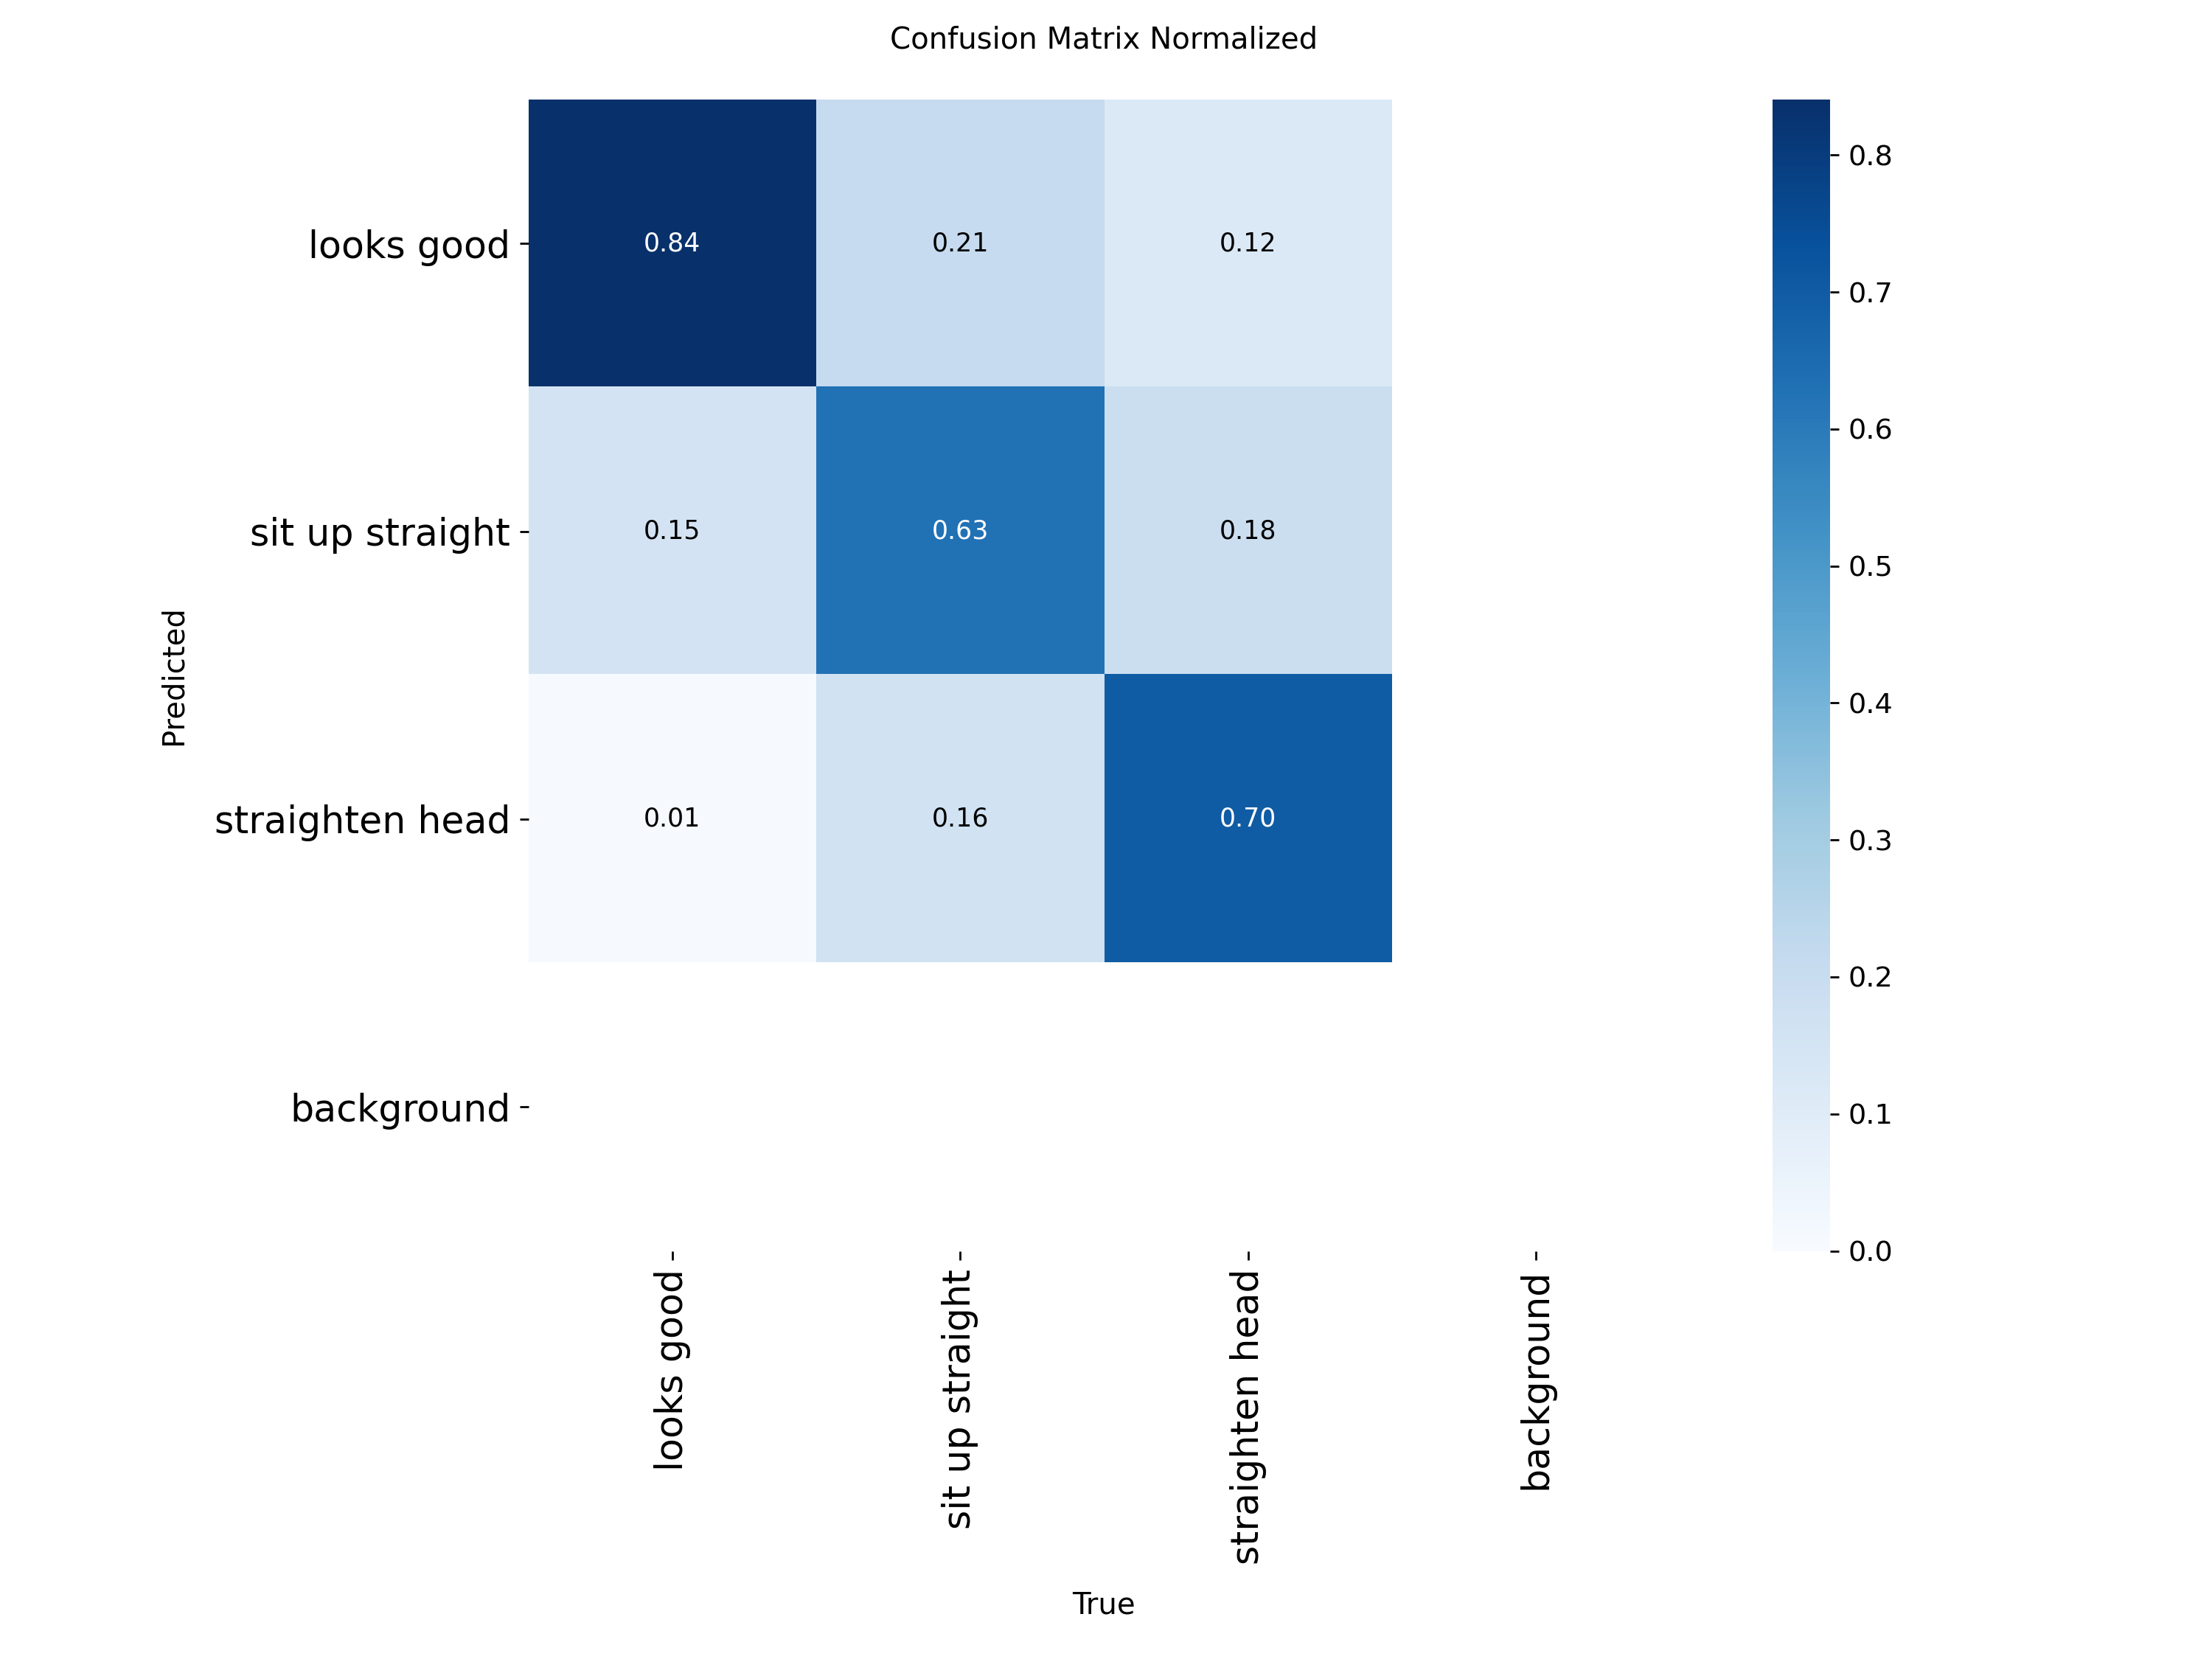

In [ ]:
%matplotlib inline
from PIL import Image

Image.open(r'runs/classify/train22/confusion_matrix_normalized.png')

##Prediction

In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO(r"runs/classify/train22/weights/best.pt")

# Predict with the model with any image from internet?
results = model('https://www.shutterstock.com/shutterstock/videos/1084300108/thumb/1.jpg?ip=x480', save=True)


image 1/1 C:\Users\User\1.jpg: 224x224 looks good 0.92, sit up straight 0.06, straighten head 0.03, 2.6ms
Speed: 2.9ms preprocess, 2.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Results saved to C:\Users\User\runs\classify\predict


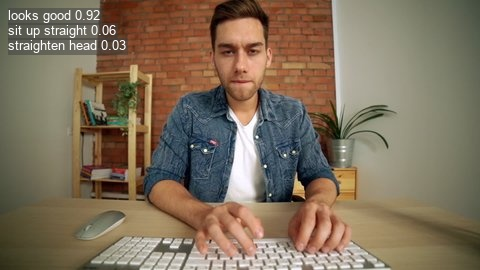

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image
import os

# The predicted image is saved inside the 'runs/classify/predict' directory.
# We need to find the image file within that directory.
predict_dir = r'runs\classify\predict'
# Assuming the saved image is named '1.jpg' based on the previous execution output
image_path = os.path.join(predict_dir, '1.jpg')

Image.open(image_path)

In [ ]:
model = YOLO(r"runs/classify/train22/weights/best.pt")

# Predict with the model with any image from internet?
results = model('https://www.shutterstock.com/image-photo/adult-blonde-woman-blue-dress-260nw-1975484504.jpg', save=True)


image 1/1 C:\Users\User\adult-blonde-woman-blue-dress-260nw-1975484504.jpg: 224x224 straighten head 0.97, sit up straight 0.03, looks good 0.00, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Results saved to C:\Users\User\runs\classify\predict6


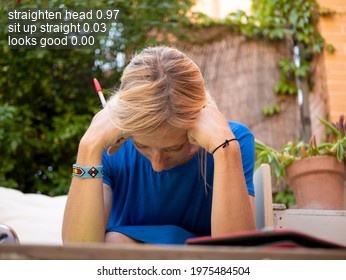

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image
import os

# The predicted image is saved inside the 'runs/classify/predict' directory.
# We need to find the image file within that directory.
predict_dir = r'runs\classify\predict6'
# Assuming the saved image is named '1.jpg' based on the previous execution output
image_path = os.path.join(predict_dir, 'adult-blonde-woman-blue-dress-260nw-1975484504.jpg')

Image.open(image_path)

In [ ]:
model = YOLO(r"runs/classify/train22/weights/best.pt")

# Predict with the model with any image from internet?
results = model('https://media.istockphoto.com/id/480730863/photo/man-hunched-over-with-pain.jpg?s=612x612&w=0&k=20&c=76_Tl_g9trHmMWQf37KDljOz4cK_x9qLWmVPiSbz5BU=', save=True)


image 1/1 C:\Users\User\man-hunched-over-with-pain.jpg: 224x224 sit up straight 0.80, straighten head 0.20, looks good 0.00, 26.5ms
Speed: 2.2ms preprocess, 26.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Results saved to C:\Users\User\runs\classify\predict7


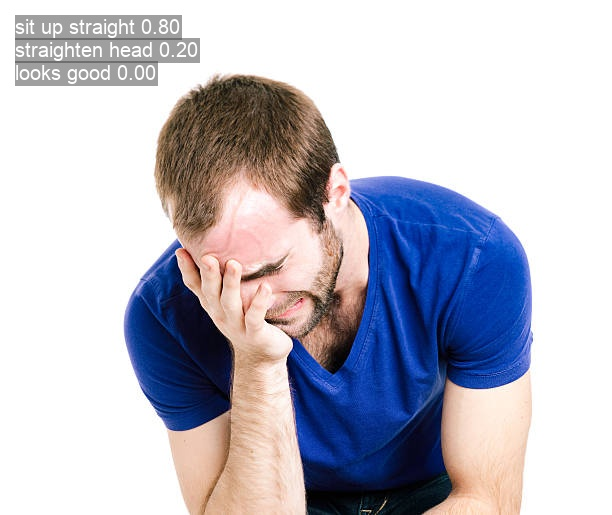

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image
import os

# The predicted image is saved inside the 'runs/classify/predict' directory.
# We need to find the image file within that directory.
predict_dir = r'runs\classify\predict7'
# Assuming the saved image is named '1.jpg' based on the previous execution output
image_path = os.path.join(predict_dir, 'man-hunched-over-with-pain.jpg')

Image.open(image_path)

In [13]:
import cv2, numpy as np
from collections import deque
from ultralytics import YOLO

# Use your working camera/index/backend on macOS
IDX, BACKEND = 0, cv2.CAP_AVFOUNDATION
WEIGHTS = '/Users/ekamnijjar/Library/CloudStorage/OneDrive-SimonFraserUniversity(1sfu)/IAT/iat 360/Projects/CV Project/best.pt'   # <- update
IMG_SIZE = 224
SMOOTH_K = 10  # moving average window for stabler labels

model = YOLO(WEIGHTS)

cap = cv2.VideoCapture(IDX, BACKEND)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,  640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

buf = deque(maxlen=SMOOTH_K)
cv2.namedWindow("Posture Monitor", cv2.WINDOW_NORMAL)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    # Run classifier on the frame (Ultralytics handles preprocessing)
    res = model.predict(source=frame, imgsz=IMG_SIZE, verbose=False)[0]
    probs = res.probs
    if probs is not None:
        scores = probs.data.cpu().numpy()     # shape [C]
        buf.append(scores)
        smoothed = np.mean(buf, axis=0)       # moving average
        cls_id = int(np.argmax(smoothed))
        conf = float(smoothed[cls_id])

        # Get class name from model (dict or list)
        names = getattr(model, "names", None) or {}
        if isinstance(names, dict):
            label = names.get(cls_id, str(cls_id))
        elif isinstance(names, (list, tuple)):
            label = names[cls_id] if cls_id < len(names) else str(cls_id)
        else:
            label = str(cls_id)

        # Draw overlay
        box_w = 360
        cv2.rectangle(frame, (10, 10), (10 + box_w, 70), (0, 0, 0), -1)
        cv2.putText(frame, f"{label}  {conf:.2f}", (20, 55),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Posture Monitor", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break  # press q to quit

cap.release()
cv2.destroyAllWindows()
